In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from configparser import ConfigParser
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [2]:
sys.path

['C:\\Users\\leada\\AlgoTradingStuff\\notebooks',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\python37.zip',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\DLLs',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff',
 '',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib\\site-packages',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib\\site-packages\\win32',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib\\site-packages\\win32\\lib',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib\\site-packages\\Pythonwin',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\leada\\.ipython']

In [3]:
if 'C:\\Users\\leada\\AlgoTradingStuff' not in sys.path:
    sys.path.append('C:\\Users\\leada\\AlgoTradingStuff')

In [4]:
from api_models.models import Account, get_account, get_accounts

In [5]:
ini = ConfigParser()
ini.read('../oanda.txt')
api_key = ini['oanda'].get('api_key')
base_url = ini['oanda'].get('base_url')
account_id = ini['oanda'].get('primary_account')

In [6]:
account = Account(api_key=api_key, base_url=base_url, account_id=account_id)

In [7]:
account

Account(api_key: <secret>, base_url: https://api-fxpractice.oanda.com/v3, account_id: 101-004-12979612-001

In [8]:
import datetime as dt
candles = account.get_candles('GBP_JPY', 
                              since=dt.datetime(2020, 1, 3), 
                              to=dt.datetime(2020, 1, 12), 
                              granularity='M30',
                              count=1000)
candles
df = pd.DataFrame(columns=['time', 'open', 'high', 'low', 'close'])
for i, candle in enumerate(candles):
    t = candle.get('time')
    ohlc = candle.get('mid')
    o = np.float32(ohlc.get('o'))
    h = np.float32(ohlc.get('h'))
    l = np.float32(ohlc.get('l'))
    c = np.float32(ohlc.get('c'))
    df.loc[i, :] = [t, o, h, l, c]
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [9]:
df.head()

,open,high,low,close
time,,,,
2019-12-20 00:30:00+00:00,142.228,142.312,142.226,142.264
2019-12-20 01:00:00+00:00,142.262,142.31,142.21,142.226
2019-12-20 01:30:00+00:00,142.224,142.365,142.198,142.363
2019-12-20 02:00:00+00:00,142.366,142.372,142.318,142.34
2019-12-20 02:30:00+00:00,142.342,142.362,142.322,142.345


In [10]:
dfpct = df.pct_change().dropna()
dfpct.head()

,open,high,low,close
time,,,,
2019-12-20 01:00:00+00:00,0.000239,-0.000014,-0.000112,-0.000267
2019-12-20 01:30:00+00:00,-0.000267,0.000387,-0.000084,0.000963
2019-12-20 02:00:00+00:00,0.000998,0.000049,0.000844,-0.000162
2019-12-20 02:30:00+00:00,-0.000169,-0.000070,0.000028,0.000035
2019-12-20 03:00:00+00:00,0.000000,0.000070,0.000035,0.000049


In [11]:
adfuller(dfpct['open'])

(-31.337492881293915,
 0.0,
 0,
 998,
 {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573},
 -11231.35971815472)

In [12]:
dfpct.describe()

,open,high,low,close
count,999.000000,999.000000,999.000000,999.000000
mean,0.000008,0.000007,0.000008,0.000007
std,0.000761,0.000664,0.000725,0.000760
min,-0.004147,-0.003471,-0.003747,-0.004071
25%,-0.000377,-0.000293,-0.000237,-0.000377
50%,0.000021,-0.000014,0.000049,0.000014
75%,0.000354,0.000281,0.000297,0.000362
max,0.004383,0.003775,0.004383,0.004411


In [13]:
import skfuzzy as fuzz
import skfuzzy.control as ctrl

In [32]:
# Define antecedents
ante_close = ctrl.Antecedent(dfpct['close'].shift(1, fill_value=0.0), 'close-1')
cons_close = ctrl.Consequent(dfpct['close'], 'close')

ante_close.automf(3)

# Quantiles for rule boundaries
df_quants = dfpct['close'].quantile([.25, .5, .75])

cons_close['sell'] = fuzz.trimf(cons_close.universe, [dfpct['close'].min(), df_quants.loc[0.25], 0])
cons_close['hold'] = fuzz.trimf(cons_close.universe, [df_quants.loc[0.25], 0, df_quants.loc[0.75]])
cons_close['buy'] = fuzz.trimf(cons_close.universe, [0, df_quants.loc[0.75], dfpct['close'].max()])

c:\users\leada\anaconda3\envs\algotradingstuff\lib\site-packages\skfuzzy\control\term.py:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


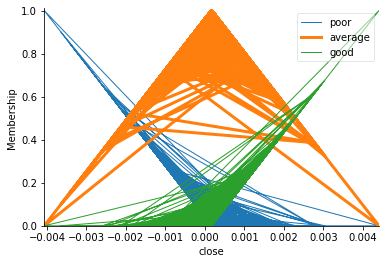

In [15]:
ante_close['average'].view()

In [34]:
# Set up the rules
rule1 = ctrl.Rule(ante_close['poor'], cons_close['sell'] | cons_close['hold'] | cons_close['buy'])
rule1 = ctrl.Rule(ante_close['average'], cons_close['sell'] | cons_close['hold'] | cons_close['buy'])
rule1 = ctrl.Rule(ante_close['good'], cons_close['sell'] | cons_close['hold'] | cons_close['buy'])
rule1.view()

ValueError: Unexpected consequent type

In [33]:
dfpct['close'].shift(1, fill_value=0.0).head()

time
2019-12-20 01:00:00+00:00    0.000000
2019-12-20 01:30:00+00:00   -0.000267
2019-12-20 02:00:00+00:00    0.000963
2019-12-20 02:30:00+00:00   -0.000162
2019-12-20 03:00:00+00:00    0.000035
Name: close, dtype: float64